# Year-long observability plot from MAGIC


In [1]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units
from astropy.coordinates import get_moon
from astropy.coordinates import get_sun
import astropy.units as u
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.pyplot import axes
import datetime
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
import ephem
from datetime import datetime, timedelta
import math
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

 Introduce the coordinates in degrees of the particular object and the coordinates of the MAGIC telescopes

In [2]:
BIGB = SkyCoord(ra=70.66917*u.degree, dec=61.67750*u.degree, frame='icrs')
print BIGB

<SkyCoord (ICRS): (ra, dec) in deg
    ( 70.66917,  61.6775)>


In [3]:
# define MAGIC Location
MAGIC = EarthLocation(lat=28.76194*u.deg, lon=-17.89*u.deg, height=2200*u.m)

# In case the year-long time didn't start in January one would nee to consider the UTC offset of +1 in the summer months
#utcoffsetSummer = +1*u.hour
utcoffsetWinter = 0*u.hour 


Set the initial date and create an array of times. In particular we are considering one year split in 30 min timesteps.

In [4]:
midnight = Time('2016-12-31 00:00:00') + utcoffsetWinter
delta_midnight = np.linspace(0,525600,17520)*u.min
times = midnight + delta_midnight

Transform the coordinates of the sun, moon and object in that time to the MAGIC horizontal coordinate system.

In [5]:
# MAGIC Horizontal Coordinate system
altazframe = AltAz(obstime=times, location=MAGIC)

In [6]:
# Moon's position in it
moonaltazs = get_moon(times).transform_to(altazframe)

In [7]:
# Sun's position in it
sunaltazs = get_sun(times).transform_to(altazframe)

In [8]:
# Object's position in int
BIGB_altazs = BIGB.transform_to(altazframe)  

For plotting, we want to to arrange the data into a matrix of size (48,365) (the number of rows is 48 because we use a 30 min timestep.)

In [9]:
BIGB_spl = np.split(BIGB_altazs,365)
B_alt=np.zeros((48,365))
B_az=np.zeros((48,365))
for i in range(365):
    B_alt[:,i]=BIGB_spl[i].alt
    B_az[:,i]=BIGB_spl[i].az

This way we can obtain a first plot of the altitude of the source object through the year

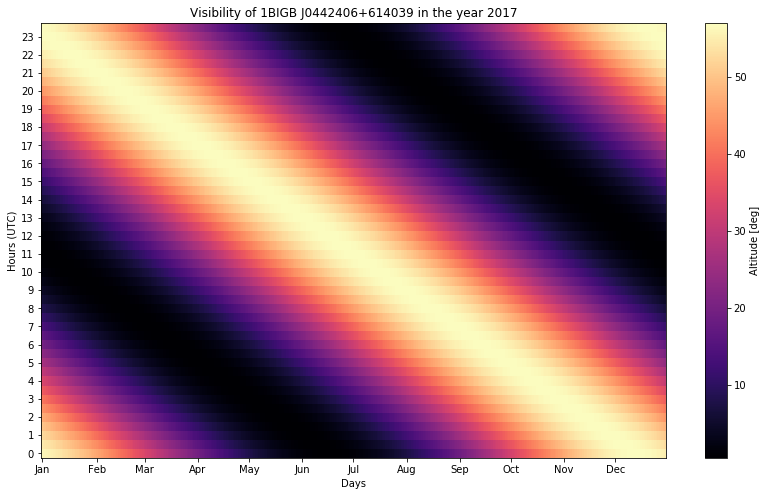

In [10]:
fig1 = plt.figure(figsize=(14,8))
    
plt.imshow(B_alt,origin='lower',cmap=cm.magma, aspect='auto')
plt.colorbar().set_label('Altitude [deg]')
plt.title("Visibility of 1BIGB J0442406+614039 in the year 2017")
plt.xticks(np.array([0,32,60,91,121,152,182,213,244,274,305,335]),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(0, 48,2),('0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))   
plt.xlabel('Days')    
plt.ylabel('Hours (UTC)')
plt.show()

Now we do the same in order to consider the effect in the visibility caused by the Moon and the Sun.

In [11]:
moon_spl = np.split(moonaltazs,365)
sun_spl = np.split(sunaltazs,365)

M_alt=np.zeros((48,365))
M_az=np.zeros((48,365))
for i in range(365):
    M_alt[:,i]=moon_spl[i].alt
    M_az[:,i]=moon_spl[i].az

S_alt=np.zeros((48,365))
S_az=np.zeros((48,365))
for i in range(365):
    S_alt[:,i]=sun_spl[i].alt
    S_az[:,i]=sun_spl[i].az

For the Sun we will neglect those times when the Sun is above the astronomical horizon, that is, -18 deg

In [12]:
S1=ma.masked_where(S_alt <= -18, S_alt)
np.putmask(S1, S1>-20, 0)

Now we can repeat the same plot with a white area representing the times when the Sun is above the horizon.

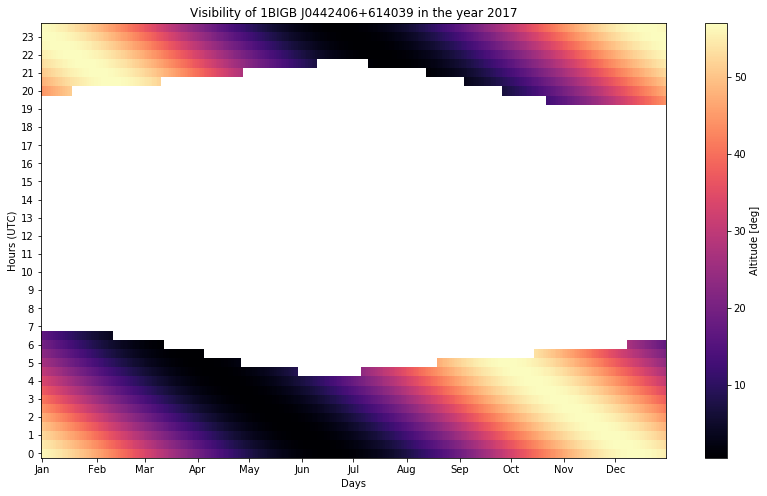

In [13]:
fig2 = plt.figure(figsize=(14,8))

plt.imshow(B_alt,origin='lower',cmap=cm.magma, aspect='auto',zorder=0)
plt.colorbar().set_label('Altitude [deg]')
plt.imshow(S1,origin='lower', cmap=cm.binary, aspect='auto',zorder=1)
#plt.colorbar().set_label('Altitude [deg]')
plt.title("Visibility of 1BIGB J0442406+614039 in the year 2017")
plt.xticks(np.array([0,32,60,91,121,152,182,213,244,274,305,335]),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(0, 48,2),('0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))   
plt.xlabel('Days')  
plt.ylabel('Hours (UTC)')
plt.show()


For the Moon we can have two situations. Either the Moon is below the horizon, which doesn't affect the observability or it is above. When the Moon is above the horizon we need to take into account the relative position of Moon and object and the brightness of the Moon (the latter is not taken into account in this notebook - yet).

In a similar fasion as before, we create a matrix in which each entry represents the distance Moon-object at a given time (row) on a given day(column). The angular distance is calculated with the formula 

  $  \theta =\cos ^{-1}\left[\sin(\delta _{1})\sin(\delta _{2})+\cos(\delta _{1})\cos(\delta _{2})\cos(\alpha _{1}-\alpha _{2})\right] $
  
  where $\theta$ is the angle, $\delta$ is the altitude and $\alpha$ the azimuth.

In [14]:
d=np.zeros((48,365))

for i in range(48):
    for j in range(365):
        d[i,j] = np.arccos(np.sin(M_alt[i,j]* np.pi / 180.)*np.sin(B_alt[i,j]* np.pi / 180.)+np.cos(M_alt[i,j]* np.pi / 180.)*np.cos(B_alt[i,j]* np.pi / 180.)*np.cos(M_az[i,j]* np.pi / 180.-B_az[i,j]* np.pi / 180.))
d=(180/np.pi)*d

We can plot this distance similarly as before:

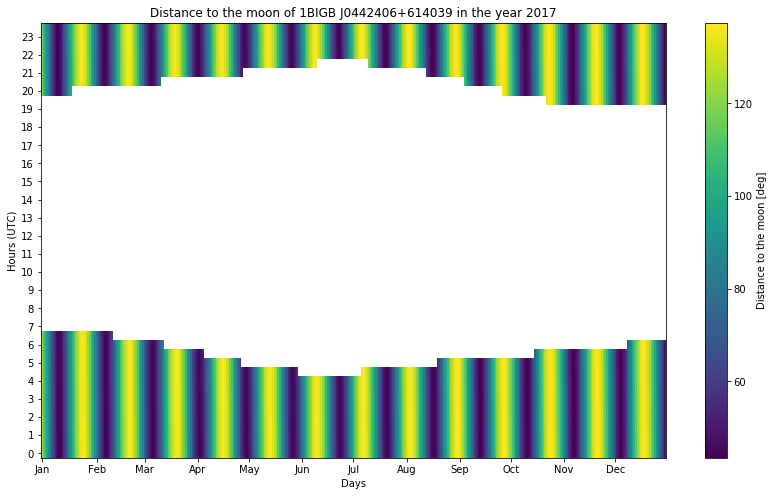

In [15]:
fig6 = plt.figure(figsize=(14,8))

plt.imshow(d,origin='lower',cmap=cm.viridis, aspect='auto',zorder=0)
plt.colorbar().set_label('Distance to the moon [deg]')
plt.imshow(S1,origin='lower', cmap=cm.binary, aspect='auto',zorder=2)
plt.title("Distance to the moon of 1BIGB J0442406+614039 in the year 2017")
plt.xticks(np.array([0,32,60,91,121,152,182,213,244,274,305,335]),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(0, 48,2),('0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))   
plt.xlabel('Days')  
plt.ylabel('Hours (UTC)')
plt.show()

Now, same as we did with the Sun before, we can overlay in the plot the times where the Moon is above the horizon (grey) and the distance to the object in those moments.

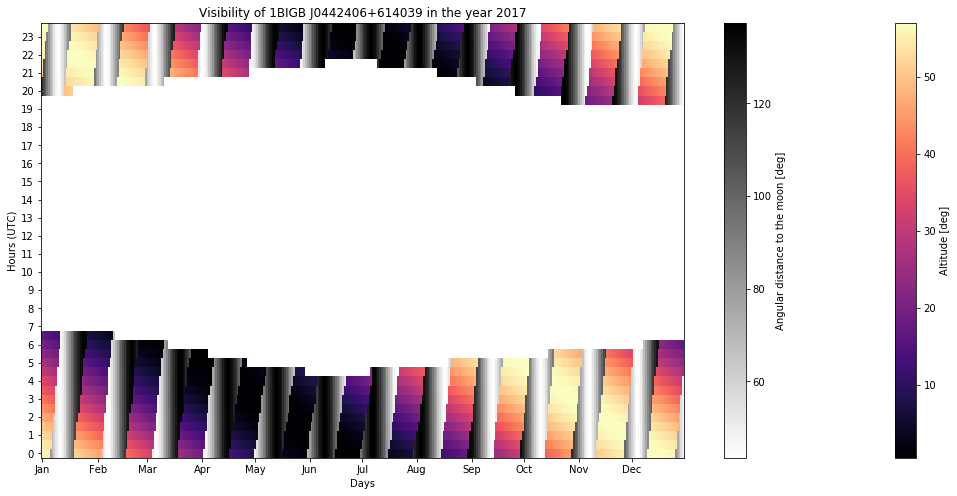

In [16]:
d=ma.masked_where(M_alt <= 0, d)


fig7 = plt.figure(figsize=(18,8))

plt.imshow(B_alt,origin='lower',cmap=cm.magma, aspect='auto',zorder=0)
plt.colorbar().set_label('Altitude [deg]')
plt.imshow(d,origin='lower',cmap=cm.binary, aspect='auto',zorder=1)
plt.colorbar().set_label('Angular distance to the moon [deg]')
plt.imshow(S1,origin='lower', cmap=cm.binary, aspect='auto',zorder=2)
#plt.colorbar().set_label('Altitude [deg]')
plt.title("Visibility of 1BIGB J0442406+614039 in the year 2017")
plt.xticks(np.array([0,32,60,91,121,152,182,213,244,274,305,335]),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(0, 48,2),('0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))   
plt.xlabel('Days')  
plt.ylabel('Hours (UTC)')
plt.show()

The Moon interferes with the observations if it is too close ($<30$ deg) or too far, since it shines from behind ($>110$ deg). We can take that into account and expand the white region of our plot, which represents the times when observation is not possible.

In [17]:
np.putmask(d, M_alt<30, 0)
np.putmask(d, M_alt>110, 0)

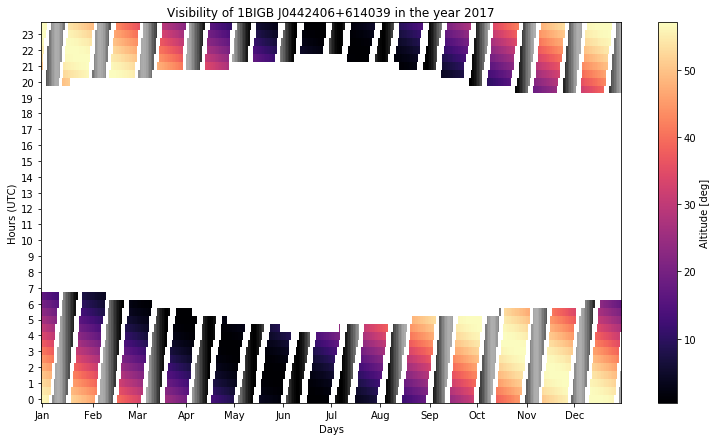

In [18]:
fig8 = plt.figure(figsize=(13,7))

plt.imshow(B_alt,origin='lower',cmap=cm.magma, aspect='auto',zorder=0)
plt.colorbar().set_label('Altitude [deg]')
plt.imshow(d,origin='lower',cmap=cm.binary, aspect='auto',zorder=1)
#plt.colorbar().set_label('Angular distance to the moon [deg]')
plt.imshow(S1,origin='lower', cmap=cm.binary, aspect='auto',zorder=2)
#plt.colorbar().set_label('Altitude [deg]')
plt.title("Visibility of 1BIGB J0442406+614039 in the year 2017")
plt.xticks(np.array([0,32,60,91,121,152,182,213,244,274,305,335]),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(0, 48,2),('0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))   
plt.xlabel('Days')  
plt.ylabel('Hours (UTC)')
plt.show()

Now even though we haven't yet accounted for the Moon brightness when it is above the horizon, we can obtain a first approximation to the number of visible hours in each angle range.

The ranges considered are 
$[h_1, h_2, h_3, h_4] = [20-28 \deg, 28-40, 40-55, 55-85]$ accounting from the ground. 

First we cancel all those entries where either the Sun is above the horizon. For a first rough approximation, we do the same with the Moon, although the real observable times are longer, sice it is possible to observe with the Moon above the horizon.


In [19]:
np.putmask(B_alt, S_alt>-18, 0)
np.putmask(B_alt, M_alt>0, 0)

In [20]:
h1d=0
h2d=0
h3d=0
h4d=0
for i in range(48):
    for j in range(365):
        if B_alt[i,j]>20 and B_alt[i,j]<28:
            h1d=h1d+1
        elif B_alt[i,j]>28 and B_alt[i,j]<40:
            h2d=h2d+1
        elif B_alt[i,j]>40 and B_alt[i,j]<55:
            h3d=h3d+1
        elif B_alt[i,j]>55 and B_alt[i,j]<85:
            h4d=h4d+1
            
            
h1=h1d/3
h2=h2d/3
h3=h3d/3
h4=h4d/3
print [h1, h2, h3, h4]
print h1+h2+h3+h4

[115, 169, 269, 118]
671
